# <center>Nonlinear classifiers</center>

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential, backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
import tensorflow_hub as hub
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import graphviz
%matplotlib inline
sns.set()

We will load data from data.npz file.

In [2]:
# Load all numpy arrays except training images (in order to save memory).
def load_data():
    with np.load('data.npz', allow_pickle=True) as npz_file:
        #X_train = npz_file['X_train']
        X_valid = npz_file['X_valid']
        X_test = npz_file['X_test']
        X_train_features = npz_file['X_train_features']
        X_valid_features = npz_file['X_valid_features']
        X_test_features = npz_file['X_test_features']
        y_train_1h = npz_file['y_train_1h']
        y_valid_1h = npz_file['y_valid_1h']
        y_test_1h = npz_file['y_test_1h']
        y_train = npz_file['y_train']
        y_valid = npz_file['y_valid']
        y_test = npz_file['y_test']
        class_indices = npz_file['class_indices']
        train_filenames = npz_file['train_filenames']
        valid_filenames = npz_file['valid_filenames']
        test_filenames = npz_file['test_filenames']
    return X_train_features, y_train_1h, y_train, train_filenames, X_valid,X_valid_features, y_valid_1h, y_valid, valid_filenames, X_test, X_test_features, y_test_1h, y_test, test_filenames,class_indices

# load training images
def load_images():
    with np.load('data.npz', allow_pickle=True) as npz_file:
        X_train = npz_file['X_train']
    return X_train

# merge two dictionaries
def merge_dict(x,y):
    d = x.copy()
    d.update(y)
    return d

# fit a model
def fit_model(model, grid, X_tr, y_tr, X_va, y_va, X_t, y_t):
    valid_scores = []
    train_scores = []
    params = []
    for params_dict in grid:
        #print (params_dict)
        params.append(params_dict)
        model.set_params(**params_dict)
        model.fit(X_tr, y_tr)
        train_scores.append(model.score(X_tr, y_tr))
        valid_scores.append(model.score(X_va, y_va))
    best_index = np.argmax(valid_scores)
    # refit model with best params
    model.set_params(**params[best_index])
    model.fit(X_tr, y_tr)
    test_score = model.score(X_t, y_t)
    return { 'best_params':params[best_index],
              'params':params,
             'train_scores':train_scores,
             'valid_scores':valid_scores,
             'test_score':test_score,
             'best_index':best_index,
              'best_valid_score':valid_scores[best_index],
              'best_model':model
            }

X_train_features, y_train_1h, y_train, train_filenames, X_valid,X_valid_features, y_valid_1h, y_valid, valid_filenames, X_test, X_test_features, y_test_1h, y_test, test_filenames,class_indices = load_data()


## Nonlinear classifiers
Try with nonlinear classifiers, can you do better than the baseline models from above?
- Try with a random Forest, does increasing the number of trees help?

In [3]:
grid = ParameterGrid({
'n_estimators'      : [50, 100, 200, 500, 1000],
'max_depth'         : range(5,15)
})

rf_model = RandomForestClassifier(random_state=0)

fit_rf = fit_model(rf_model, grid, X_train_features, y_train, X_valid_features, y_valid, X_test_features, y_test)

Best params, best validation score, and test accuracy score are :

In [4]:
print('Best params : ', fit_rf['best_params'])
print('Best validation score : ', fit_rf['best_valid_score'])
print('Test score : ', fit_rf['test_score'])

Best params :  {'max_depth': 10, 'n_estimators': 200}
Best validation score :  0.920863309352518
Test score :  0.92


Grid search results are : 

In [5]:
rf = pd.DataFrame([ merge_dict(x, {'valid_score':fit_rf['valid_scores'][i],'train_score':fit_rf['train_scores'][i]}) for i, x in enumerate(fit_rf['params']) ])
rf

,max_depth,n_estimators,train_score,valid_score
0,5,50,0.948571,0.884892
1,5,100,0.955714,0.877698
2,5,200,0.952857,0.884892
3,5,500,0.953571,0.884892
4,5,1000,0.956429,0.870504
5,6,50,0.974286,0.906475
6,6,100,0.977143,0.906475
7,6,200,0.977857,0.906475
8,6,500,0.979286,0.906475
9,6,1000,0.980000,0.913669


Chart of grid search results :

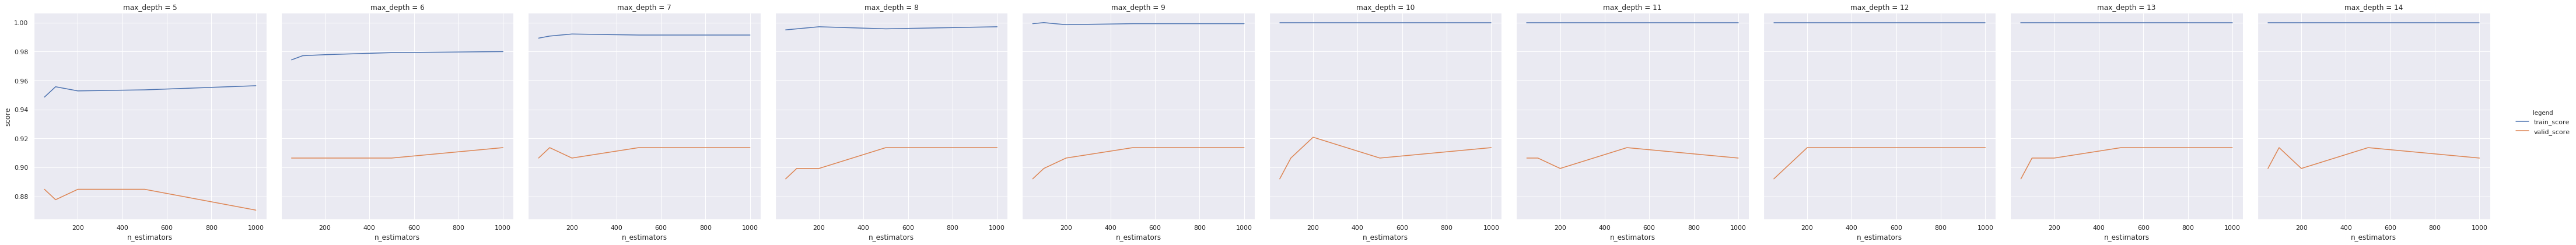

In [6]:
data=pd.melt(rf, id_vars=['max_depth','n_estimators'], value_vars=['train_score','valid_score'], var_name='legend', value_name='score')
g = sns.FacetGrid(data, col="max_depth",hue="legend",height=6)
g = g.map(sns.lineplot, "n_estimators", "score")
g.add_legend();

The best test score is 92% which is less than the baseline (94% for KNN).

Increasing the number of trees does NOT help because validation score becomes stable after 500 estimators. Increasing number of trees reduces variance but maintains bias.

- Try with SVMs - does the RBF kernel perform better than the linear one?

In [7]:
grid = ParameterGrid({
'C'      : np.logspace(-4, 4, 9),
'kernel'         : ['linear', 'rbf']
})

svm_model = SVC(random_state=0, gamma='auto')

fit_svm = fit_model(svm_model, grid, X_train_features, y_train, X_valid_features, y_valid, X_test_features, y_test)

Best params, best validation score, and test accuracy score are :

In [8]:
print('Best params : ', fit_svm['best_params'])
print('Best validation score : ', fit_svm['best_valid_score'])
print('Test score : ', fit_svm['test_score'])

Best params :  {'C': 0.001, 'kernel': 'linear'}
Best validation score :  0.920863309352518
Test score :  0.94


Grid search results are : 

In [9]:
svm = pd.DataFrame([ merge_dict(x, {'valid_score':fit_svm['valid_scores'][i],'train_score':fit_svm['train_scores'][i]}) for i, x in enumerate(fit_svm['params']) ])
svm

,C,kernel,train_score,valid_score
0,0.0001,linear,0.785714,0.776978
1,0.0001,rbf,0.235714,0.237410
2,0.0010,linear,0.955714,0.920863
3,0.0010,rbf,0.235714,0.237410
4,0.0100,linear,0.996429,0.913669
5,0.0100,rbf,0.235714,0.237410
6,0.1000,linear,1.000000,0.913669
7,0.1000,rbf,0.776429,0.791367
8,1.0000,linear,1.000000,0.913669
9,1.0000,rbf,0.954286,0.920863


Chart of grid serach results :

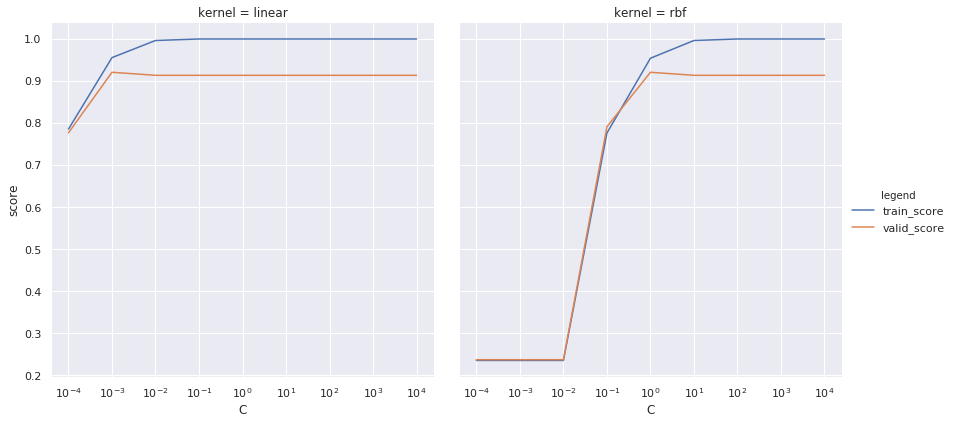

In [10]:
data=pd.melt(svm, id_vars=['kernel','C'], value_vars=['train_score','valid_score'], var_name='legend', value_name='score')
g = sns.FacetGrid(data, col="kernel",hue="legend",height=6)
g = g.map(sns.lineplot, "C", "score").set(xscale = 'log')
g.add_legend();

The best test score is 94% which is the same as the baseline (94% for KNN).

For validation scores, we can see that rbf and linear kernels has the same performance.

For test scores :

In [11]:
svm[svm.kernel=='linear']

,C,kernel,train_score,valid_score
0,0.0001,linear,0.785714,0.776978
2,0.0010,linear,0.955714,0.920863
4,0.0100,linear,0.996429,0.913669
6,0.1000,linear,1.000000,0.913669
8,1.0000,linear,1.000000,0.913669
10,10.0000,linear,1.000000,0.913669
12,100.0000,linear,1.000000,0.913669
14,1000.0000,linear,1.000000,0.913669
16,10000.0000,linear,1.000000,0.913669


In [12]:
svm[svm.kernel=='rbf']

,C,kernel,train_score,valid_score
1,0.0001,rbf,0.235714,0.237410
3,0.0010,rbf,0.235714,0.237410
5,0.0100,rbf,0.235714,0.237410
7,0.1000,rbf,0.776429,0.791367
9,1.0000,rbf,0.954286,0.920863
11,10.0000,rbf,0.996429,0.913669
13,100.0000,rbf,1.000000,0.913669
15,1000.0000,rbf,1.000000,0.913669
17,10000.0000,rbf,1.000000,0.913669


In [13]:
svm_linear = SVC(random_state=0, gamma='auto', kernel='linear', C=0.001)
svm_rbf = SVC(random_state=0, gamma='auto', kernel='rbf', C=1)
svm_linear.fit(X_train_features, y_train)
svm_rbf.fit(X_train_features, y_train)
print ("Linear SVM test score :", svm_linear.score(X_test_features, y_test))
print ("RBF    SVM test score :", svm_rbf.score(X_test_features, y_test))

Linear SVM test score : 0.94
RBF    SVM test score : 0.94


As we can see, RBF kernel does not perfom better than linear one. In high dimension spaces, rbf does not generally performs than linear kernel.